# Empirical Data Exploratory Analysis

This notebook contains exploratory data analysis for empirical data.

## Import libraries

In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import re
import io
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
import re
import csv
import io
from rich import print
import seaborn as sns
# Set the style for a professional academic look
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

## Load data

In [2]:


# --- Configuration ---
# Define the path to your Fama-French data file
file_path = "../../Data/Fama_french/100_Portfolios_10x10.CSV" # Using path provided by user

# Keywords often found in header/marker lines preceding data blocks
keywords = [
    "Average", "Returns", "Number of Firms", "Sum of",
    "Value Weight", "Equal Weight", "Size", "BE/ME",
    "Monthly", "Annual", "Portfolio", "Portfolios"
]
# Minimum number of commas to guess if a line might be CSV data/header
min_commas_for_header = 5 # Threshold for headers
min_commas_for_data = 3   # Threshold for data

# --- Helper Functions ---
def line_looks_like_data(line_stripped, min_commas):
    """Checks if a line looks like a typical data row (starts numeric, has commas)."""
    if not line_stripped:
        return False
    parts = line_stripped.split(',')
    if not parts: return False # Handle empty lines split
    try:
        float(parts[0].strip())
        is_first_part_numeric = True
    except ValueError:
        is_first_part_numeric = False
    return is_first_part_numeric and line_stripped.count(',') >= min_commas

def line_looks_like_header(line_stripped, min_commas):
    """Checks if a line looks like a CSV header row (many commas, maybe non-numeric start)."""
    if not line_stripped:
        return False
    # A header often has many commas
    has_enough_commas = line_stripped.count(',') >= min_commas
    # Optional: Check if it likely contains non-numeric characters typical of headers
    has_text = bool(re.search(r'[a-zA-Z]', line_stripped))
    # Optional: Check if it *doesn't* look like a standard data row
    # is_data = line_looks_like_data(line_stripped, min_commas_for_data) # Avoid circularity if thresholds differ

    # Primarily rely on comma count and presence of text
    return has_enough_commas and has_text # and not is_data

# --- Function to Identify Blocks ---
def identify_potential_blocks(filepath, keywords_list, min_commas_hdr, min_commas_data):
    """Scans a file line by line to identify potential data block start points."""
    potential_blocks = []
    lines = []
    try:
        with io.open(filepath, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    except UnicodeDecodeError:
        print("UTF-8 encoding failed, trying latin1...")
        with io.open(filepath, 'r', encoding='latin1') as f:
            lines = f.readlines()
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return []
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return []

    identified_lines = set() # Keep track of lines already marked as start points

    # Iterate through lines, looking for potential markers
    for i, line in enumerate(lines):
        line_stripped = line.strip()

        if not line_stripped or i in identified_lines:
            continue

        # --- Heuristic 1: Standard Title (keywords + '--') followed by data/header ---
        contains_keywords = any(keyword.lower() in line_stripped.lower() for keyword in keywords_list)
        looks_like_std_title = contains_keywords and "--" in line_stripped
        next_line_looks_ok = False
        if i + 1 < len(lines):
            next_line_stripped = lines[i+1].strip()
            if next_line_stripped:
                 next_line_looks_ok = line_looks_like_data(next_line_stripped, min_commas_data) or \
                                      line_looks_like_header(next_line_stripped, min_commas_hdr)

        if looks_like_std_title and next_line_looks_ok:
            if i not in identified_lines:
                 # Check if the previous identified block wasn't the immediately preceding line
                 is_new_block = True
                 if potential_blocks:
                     last_block_line = potential_blocks[-1]['line_number']
                     if i - last_block_line <= 2: # Allow for a blank line gap perhaps
                         is_new_block = False

                 if is_new_block:
                    potential_blocks.append({
                        "line_number": i,
                        "marker_text": line_stripped,
                        "reason": "Standard Title (--)"
                    })
                    identified_lines.add(i)
                    continue # Prioritize this type of match

        # --- Heuristic 2: Header line found, look backwards for description ---
        is_header = line_looks_like_header(line_stripped, min_commas_hdr)
        if is_header:
            # Look back up to 5 lines for the first non-blank, non-data line containing keywords
            found_description = False
            for j in range(i - 1, max(-1, i - 6), -1): # Look back from i-1 down to i-5
                if j < 0: break # Stop if we reach beginning of file
                prev_line_stripped = lines[j].strip()

                if not prev_line_stripped: # Skip blank lines
                    continue

                # Check if this previous line looks like a description
                prev_contains_keywords = any(keyword.lower() in prev_line_stripped.lower() for keyword in keywords_list)
                prev_is_data = line_looks_like_data(prev_line_stripped, min_commas_data)

                if prev_contains_keywords and not prev_is_data:
                    # Found a likely description line! Mark line j as the start.
                    # Avoid adding if j is too close to the previously identified block start
                    if j not in identified_lines:
                        is_new_block = True
                        if potential_blocks:
                            last_block_line = potential_blocks[-1]['line_number']
                            # Check if this found description line 'j' is sufficiently after the last block
                            if j - last_block_line <= 5: # Heuristic: Allow some gap, but not too close
                                # Also check if the header 'i' is very close to the last identified line
                                if i - last_block_line <= 5:
                                     is_new_block = False # Likely part of the previous block's header/desc

                        if is_new_block:
                            potential_blocks.append({
                                "line_number": j, # Mark the description line
                                "marker_text": prev_line_stripped,
                                "reason": f"Description Found Before Header on Line {i+1}"
                            })
                            identified_lines.add(j)
                            found_description = True
                            break # Stop looking back once description found

            # If we found a description by looking back, continue to next line 'i'
            # This prevents the header line 'i' itself from being flagged by other heuristics later
            if found_description:
                 identified_lines.add(i) # Mark header line as processed too
                 continue


    # --- Post-processing: Sort results ---
    potential_blocks.sort(key=lambda x: x['line_number'])

    # Filter out blocks starting too close to each other (can happen with multi-line headers/titles)
    final_blocks = []
    last_line = -10 # Initialize far back
    for block in potential_blocks:
        if block['line_number'] - last_line > 2: # Only keep if sufficiently spaced from the last kept block
             final_blocks.append(block)
             last_line = block['line_number']
        # else:
            # print(f"Filtering out block at line {block['line_number']+1} due to proximity to previous.")


    return final_blocks

# --- Main Execution ---
print(f"Scanning '{file_path}' for potential data block markers (v3)...")
blocks = identify_potential_blocks(file_path, keywords, min_commas_for_header, min_commas_for_data)

if blocks:
    print("\nFound potential data block starting points:")
    for block in blocks:
        # Add 1 to line_number for conventional 1-based line counting for display
        print(f"  Line {block['line_number'] + 1}: {block['marker_text']} (Reason: {block['reason']})")
    print("\nNote: These are potential markers. Please review the file around these lines.")
    print("The actual data usually starts on the line *after* the marker, or sometimes after the header line following the marker.")
else:
    print("Could not automatically identify distinct data blocks based on the v3 heuristics.")
    print("You may need to manually inspect the file to find the section headers.")


Scanning '../../Data/Fama_french/100_Portfolios_10x10.CSV' for potential data block markers (v3)...

Found potential data block starting points:

Line 15: Average Value Weighted Returns -- Monthly (Reason: Standard Title (--))

Line 1201: Average Equal Weighted Returns -- Monthly (Reason: Standard Title (--))

Line 2387: Average Value Weighted Returns -- Annual (Reason: Standard Title (--))

Line 2489: Average Equal Weighted Returns -- Annual (Reason: Standard Title (--))

Line 2591: Number of Firms in Portfolios (Reason: Description Found Before Header on Line 2592)

Line 3777: Average Market Cap (Reason: Description Found Before Header on Line 3778)

Line 4964: Value Weight Average of BE/ME Calculated for June of t to June of t+1 as: (Reason: Description Found 
Before Header on Line 4968)

Line 6154: Value Weight Average of BE_FYt-1/ME_June t Calculated for June of t to June of t+1 as: (Reason: 
Description Found Before Header on Line 6158)

Line 7344: Value Weight Average of OP Calculated as: (Reason: Description Found Before Header on Line 7347)

Line 8089: Value Weight Average of investment (rate of growth of assets) Calculated as: (Reason: Description 
Found Before Header on Line 8092)

Note: These are potential markers. Please review the file around these lines.

The actual data usually starts on the line *after* the marker, or sometimes after the header line following the 
marker.

In [3]:
# --- Configuration ---
file_path = '../../Data/Fama_french/100_Portfolios_10x10.CSV' # Using path provided by user
missing_value = ["-99.99","-999","-99.9900"]

# Define the blocks to load based on the identifier script's output
# Format: block_name: (marker_line_0_indexed, next_block_marker_line_0_indexed)
# Use the line numbers where the *marker text* was found.
# The header is assumed to be on the line *after* the marker line for standard titles,
# or identified explicitly by the look-back heuristic.
block_info = {
    "VW_Returns_Monthly": (14, 1200), # Marker line 14 ("Avg VW Returns -- Monthly"), next marker line 1200 ("Avg EW Returns -- Monthly")
    "EW_Returns_Monthly": (1200, 2386), # Marker line 1200, next marker line 2386 ("Avg VW Returns -- Annual")
    "Num_Firms": (2590, 3776), # Marker line 2590 ("Num Firms..."), next marker line 3776 ("Avg Mkt Cap...")
    "Avg_Mkt_Cap": (3776, 4963) # Marker line 3776, next marker line 4963 ("VW Avg BE/ME...")
    # Note: Using line numbers (0-indexed) of the marker lines identified previously.
    # The end line for the last block (Avg_Mkt_Cap) is the line before the next marker (4964-1 = 4963).
}

# --- Function to load and clean a specific block ---
def load_fama_french_block(filepath, block_name, marker_line, next_marker_line, null_val):
    """Loads a specific block of Fama-French data using Polars."""
    try:
        # Calculate skip_rows: Skip lines up to and including the marker line.
        # The header is expected on the line immediately after the marker line.
        # Example: If marker is line 14 (0-indexed), header is line 15. skip_rows should be 15.
        rows_to_skip = marker_line + 1

        # Calculate n_rows: Number of data rows between the current header and the next marker.
        # header_line = marker_line + 1
        # data_start_line = header_line + 1
        # data_end_line = next_marker_line - 1
        # n_rows = data_end_line - data_start_line + 1 = (next_marker_line - 1) - (marker_line + 1 + 1) + 1
        # n_rows = next_marker_line - marker_line - 2
        # However, polars n_rows reads *at most* n_rows *after* skipping rows *before* the header.
        # If header is at rows_to_skip, data starts at rows_to_skip + 1.
        # We want to read up to line next_marker_line - 1.
        # Total lines in block = next_marker_line - rows_to_skip
        # Number of data rows = Total lines in block - 1 (for header) = next_marker_line - rows_to_skip - 1
        n_rows_to_read = next_marker_line - rows_to_skip

        print(f"Loading block '{block_name}':")
        print(f"  Marker Line (0-idx): {marker_line}")
        print(f"  Header Line (0-idx): {rows_to_skip}")
        print(f"  Next Marker Line (0-idx): {next_marker_line}")
        print(f"  Calculated skip_rows: {rows_to_skip}")
        print(f"  Calculated n_rows: {n_rows_to_read}")


        df = pl.read_csv(
            filepath,
            skip_rows=rows_to_skip, # Skip lines *before* the header
            n_rows=n_rows_to_read,  # Read this many rows *after* skipping
            has_header=True,        # The first row read (after skipping) is the header
            null_values=null_val,
            separator=",",
            ignore_errors=True,     # Try to ignore rows that cause parsing errors
            encoding='utf-8',
            try_parse_dates=True,  
        )

        # --- Data Cleaning ---
        # Rename the first column (date) - often unnamed or 'Unnamed: 0'
        date_col_name = df.columns[0]
        df = df.rename({date_col_name: "Date"})

        # Convert Date column to string first to handle potential mixed types/whitespace
        df = df.with_columns(pl.col("Date").cast(pl.Utf8))

        # Filter out rows where 'Date' is not numeric (removes potential footers/text)
        df = df.filter(pl.col("Date").is_not_null() & pl.col("Date").str.contains(r"^\s*\d+\s*$"))

        # Convert Date column to actual Date type (YYYYMM format)
        # Use strict=False to handle potential parsing errors gracefully (results in null)
        df = df.with_columns(
            pl.col("Date").str.strip_chars().str.strptime(pl.Date, format="%Y%m", strict=False).alias("Date")
        )

        # Convert all other columns to Float64 (suitable for returns, market cap, and can handle NaNs in Num Firms)
        value_columns = df.columns[1:] # Exclude the 'Date' column
        df = df.with_columns(
            [pl.col(c).str.strip_chars().cast(pl.Float64, strict=False) for c in value_columns]
        )

        # Drop rows with invalid dates (NaT) or where all values are null
        df = df.drop_nulls(subset=["Date"])
        df = df.filter(pl.sum_horizontal(pl.all().is_not_null()) > 1) # Keep rows with Date + at least one value

        # Optional: Convert returns from percent to decimal (uncomment if needed)
        # if "Returns" in block_name:
        #     print(f"  Converting returns in '{block_name}' to decimals...")
        #     for col_name in value_columns:
        #         df = df.with_columns((pl.col(col_name) / 100.0).alias(col_name))

        # Set Date as index (Polars doesn't have a direct index like pandas, but sorting helps)
        df = df.sort("Date")

        print(f"  Successfully loaded and processed block '{block_name}'. Shape: {df.shape}")
        return df

    except pl.NoDataError:
        print(f"Warning: No data found for block '{block_name}'. Check markers and file structure.")
        return None
    except Exception as e:
        print(f"An error occurred processing block '{block_name}': {e}")
        import traceback
        traceback.print_exc() # Print detailed traceback for debugging
        return None

# --- Main Execution ---
loaded_data = {}
blocks_to_load = [
    "VW_Returns_Monthly",
    "EW_Returns_Monthly",
    "Num_Firms",
    "Avg_Mkt_Cap"
]

for block_name in blocks_to_load:
    if block_name in block_info:
        marker_line, next_marker_line = block_info[block_name]
        try:
            # Attempt to load using utf-8 first
            df = load_fama_french_block(file_path, block_name, marker_line, next_marker_line, missing_value)
            if df is None and isinstance(e, UnicodeDecodeError): # Check if loading failed due to encoding
                 raise UnicodeDecodeError # Re-raise to trigger latin1 attempt
            loaded_data[block_name] = df
        except UnicodeDecodeError:
             # If utf-8 fails, try latin1
            print(f"UTF-8 failed for {block_name}, trying latin1...")
            try:
                 df = load_fama_french_block(file_path.replace('utf-8', 'latin1'), block_name, marker_line, next_marker_line, missing_value)
                 loaded_data[block_name] = df
            except Exception as e_latin1:
                 print(f"Latin1 encoding also failed for block '{block_name}': {e_latin1}")
                 loaded_data[block_name] = None
        except Exception as e:
             # Catch other potential errors during loading
             print(f"Failed to load block '{block_name}' due to error: {e}")
             loaded_data[block_name] = None # Ensure key exists even if loading fails
    else:
        print(f"Warning: Block information for '{block_name}' not found.")
        loaded_data[block_name] = None


# --- Display Results ---
print("\n--- Loaded Data Summary ---")
for block_name, df in loaded_data.items():
    print(f"\n--- {block_name} ---")
    if df is not None:
        print(df.head())
        # print(df.describe()) # Uncomment for summary stats
    else:
        print("Failed to load.")
# rep

Loading block 'VW_Returns_Monthly':

Marker Line (0-idx): 14

Header Line (0-idx): 15

Next Marker Line (0-idx): 1200

Calculated skip_rows: 15

Calculated n_rows: 1185

Successfully loaded and processed block 'VW_Returns_Monthly'. Shape: (1182, 101)

Loading block 'EW_Returns_Monthly':

Marker Line (0-idx): 1200

Header Line (0-idx): 1201

Next Marker Line (0-idx): 2386

Calculated skip_rows: 1201

Calculated n_rows: 1185

Successfully loaded and processed block 'EW_Returns_Monthly'. Shape: (1182, 101)

Loading block 'Num_Firms':

Marker Line (0-idx): 2590

Header Line (0-idx): 2591

Next Marker Line (0-idx): 3776

Calculated skip_rows: 2591

Calculated n_rows: 1185

Successfully loaded and processed block 'Num_Firms'. Shape: (1182, 101)

Loading block 'Avg_Mkt_Cap':

Marker Line (0-idx): 3776

Header Line (0-idx): 3777

Next Marker Line (0-idx): 4963

Calculated skip_rows: 3777

Calculated n_rows: 1186

Successfully loaded and processed block 'Avg_Mkt_Cap'. Shape: (1182, 101)

--- Loaded Data Summary ---

--- VW_Returns_Monthly ---

shape: (5, 101)
┌────────────┬────────────┬─────────┬─────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ Date       ┆ SMALL LoBM ┆ ME1 BM2 ┆ ME1 BM3 ┆ … ┆ ME10 BM7 ┆ ME10 BM8 ┆ ME10 BM9 ┆ BIG HiBM │
│ ---        ┆ ---        ┆ ---     ┆ ---     ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ date       ┆ f64        ┆ f64     ┆ f64     ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞════════════╪════════════╪═════════╪═════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 1926-07-01 ┆ -99.99     ┆ 12.3656 ┆ -99.99  ┆ … ┆ 2.7332   ┆ 3.5356   ┆ 0.8576   ┆ -99.99   │
│ 1926-08-01 ┆ -99.99     ┆ 2.9904  ┆ -99.99  ┆ … ┆ 6.7182   ┆ 3.237    ┆ 11.2245  ┆ -99.99   │
│ 1926-09-01 ┆ -99.99     ┆ -18.583 ┆ -99.99  ┆ … ┆ -0.5241  ┆ -0.8665  ┆ -1.0703  ┆ -99.99   │
│ 1926-10-01 ┆ -99.99     ┆ -4.1369 ┆ -99.99  ┆ … ┆ -5.5678  ┆ -1.8602  ┆ -3.9246  ┆ -99.99   │
│ 1926-11-01 ┆ -99.99     ┆ -8.2589 ┆ -99.99  ┆ … ┆ 3.9514   ┆ 2.3695   ┆ 3.268    ┆ -99.99   │
└────────────┴────────────┴─────────┴─────────┴───┴──────────┴──────────┴──────────┴──────────┘

--- EW_Returns_Monthly ---

shape: (5, 101)
┌────────────┬────────────┬──────────┬─────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ Date       ┆ SMALL LoBM ┆ ME1 BM2  ┆ ME1 BM3 ┆ … ┆ ME10 BM7 ┆ ME10 BM8 ┆ ME10 BM9 ┆ BIG HiBM │
│ ---        ┆ ---        ┆ ---      ┆ ---     ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ date       ┆ f64        ┆ f64      ┆ f64     ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞════════════╪════════════╪══════════╪═════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 1926-07-01 ┆ -99.99     ┆ 11.3757  ┆ -99.99  ┆ … ┆ 3.4956   ┆ 4.0253   ┆ 0.8576   ┆ -99.99   │
│ 1926-08-01 ┆ -99.99     ┆ 3.9643   ┆ -99.99  ┆ … ┆ 6.9075   ┆ 2.905    ┆ 11.2245  ┆ -99.99   │
│ 1926-09-01 ┆ -99.99     ┆ -19.3658 ┆ -99.99  ┆ … ┆ -0.4491  ┆ -0.8531  ┆ -1.0703  ┆ -99.99   │
│ 1926-10-01 ┆ -99.99     ┆ -4.9361  ┆ -99.99  ┆ … ┆ -4.4929  ┆ -1.9998  ┆ -3.9246  ┆ -99.99   │
│ 1926-11-01 ┆ -99.99     ┆ -10.4167 ┆ -99.99  ┆ … ┆ 2.3656   ┆ 2.1261   ┆ 3.268    ┆ -99.99   │
└────────────┴────────────┴──────────┴─────────┴───┴──────────┴──────────┴──────────┴──────────┘

--- Num_Firms ---

shape: (5, 101)
┌────────────┬────────────┬─────────┬─────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ Date       ┆ SMALL LoBM ┆ ME1 BM2 ┆ ME1 BM3 ┆ … ┆ ME10 BM7 ┆ ME10 BM8 ┆ ME10 BM9 ┆ BIG HiBM │
│ ---        ┆ ---        ┆ ---     ┆ ---     ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ date       ┆ f64        ┆ f64     ┆ f64     ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞════════════╪════════════╪═════════╪═════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 1926-07-01 ┆ 0.0        ┆ 2.0     ┆ 0.0     ┆ … ┆ 5.0      ┆ 2.0      ┆ 1.0      ┆ 0.0      │
│ 1926-08-01 ┆ 0.0        ┆ 2.0     ┆ 0.0     ┆ … ┆ 5.0      ┆ 2.0      ┆ 1.0      ┆ 0.0      │
│ 1926-09-01 ┆ 0.0        ┆ 2.0     ┆ 0.0     ┆ … ┆ 5.0      ┆ 2.0      ┆ 1.0      ┆ 0.0      │
│ 1926-10-01 ┆ 0.0        ┆ 2.0     ┆ 0.0     ┆ … ┆ 5.0      ┆ 2.0      ┆ 1.0      ┆ 0.0      │
│ 1926-11-01 ┆ 0.0        ┆ 2.0     ┆ 0.0     ┆ … ┆ 5.0      ┆ 2.0      ┆ 1.0      ┆ 0.0      │
└────────────┴────────────┴─────────┴─────────┴───┴──────────┴──────────┴──────────┴──────────┘

--- Avg_Mkt_Cap ---

shape: (5, 101)
┌────────────┬────────────┬─────────┬─────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ Date       ┆ SMALL LoBM ┆ ME1 BM2 ┆ ME1 BM3 ┆ … ┆ ME10 BM7 ┆ ME10 BM8 ┆ ME10 BM9 ┆ BIG HiBM │
│ ---        ┆ ---        ┆ ---     ┆ ---     ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ date       ┆ f64        ┆ f64     ┆ f64     ┆   ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞════════════╪════════════╪═════════╪═════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 1926-07-01 ┆ -99.99     ┆ 0.93    ┆ -99.99  ┆ … ┆ 297.42   ┆ 162.59   ┆ 180.73   ┆ -99.99   │
│ 1926-08-01 ┆ -99.99     ┆ 1.05    ┆ -99.99  ┆ … ┆ 303.94   ┆ 167.22   ┆ 182.28   ┆ -99.99   │
│ 1926-09-01 ┆ -99.99     ┆ 1.08    ┆ -99.99  ┆ … ┆ 322.14   ┆ 172.63   ┆ 202.74   ┆ -99.99   │
│ 1926-10-01 ┆ -99.99     ┆ 0.88    ┆ -99.99  ┆ … ┆ 320.04   ┆ 171.13   ┆ 197.47   ┆ -99.99   │
│ 1926-11-01 ┆ -99.99     ┆ 0.84    ┆ -99.99  ┆ … ┆ 300.95   ┆ 166.83   ┆ 189.72   ┆ -99.99   │
└────────────┴────────────┴─────────┴─────────┴───┴──────────┴──────────┴──────────┴──────────┘

In [4]:
loaded_data.keys()
#create dir

os.makedirs("../../Data/Fama_french/100_portfolios_monthly", exist_ok=True)
#Save loaded data as parquet in folder
for key, value in loaded_data.items():
    value.write_parquet(f"../../Data/Fama_french/100_portfolios_monthly/{key}.parquet")
    value.write_csv(f"../../Data/Fama_french/100_portfolios_monthly/{key}.csv")

In [5]:
loaded_data.keys()
vw_returns=loaded_data["VW_Returns_Monthly"] #Will use vw returns
ew_returns=loaded_data["EW_Returns_Monthly"]
mkt_cap=loaded_data["Avg_Mkt_Cap"]
num_firms=loaded_data["Num_Firms"]
#Use july 1963 as start date, which is standard
start_date = pl.date(1963, 7, 1)
vw_returns=vw_returns.filter(pl.col("Date") >= start_date)
ew_returns=ew_returns.filter(pl.col("Date") >= start_date)
mkt_cap=mkt_cap.filter(pl.col("Date") >= start_date)
num_firms=num_firms.filter(pl.col("Date") >= start_date)
#Replace -99.99 with NaN
vw_returns = vw_returns.with_columns(pl.all().replace(-99.99, None))
vw_returns=vw_returns.with_columns((pl.exclude("Date") / 100)) #Convert from percentage to decimal
ew_returns = ew_returns.with_columns(pl.all().replace(-99.99, None)).with_columns((pl.exclude("Date") / 100))
#Demean

vw_returns_demeaned = vw_returns.with_columns([
    pl.col("Date"),  # Keep Date column unchanged
    pl.exclude("Date") - pl.exclude("Date").mean()  # Subtract means from all other columns
])
ew_returns_demeaned = ew_returns.with_columns([
    pl.col("Date"),  # Keep Date column unchanged
    pl.exclude("Date") - pl.exclude("Date").mean()  # Subtract means from all other columns
])
vw_returns_demeaned.head()

Date,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,ME2 BM6,ME2 BM7,ME2 BM8,ME2 BM9,ME2 BM10,ME3 BM1,ME3 BM2,ME3 BM3,ME3 BM4,ME3 BM5,ME3 BM6,ME3 BM7,ME3 BM8,ME3 BM9,ME3 BM10,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,ME4 BM6,…,ME7 BM4,ME7 BM5,ME7 BM6,ME7 BM7,ME7 BM8,ME7 BM9,ME7 BM10,ME8 BM1,ME8 BM2,ME8 BM3,ME8 BM4,ME8 BM5,ME8 BM6,ME8 BM7,ME8 BM8,ME8 BM9,ME8 BM10,ME9 BM1,ME9 BM2,ME9 BM3,ME9 BM4,ME9 BM5,ME9 BM6,ME9 BM7,ME9 BM8,ME9 BM9,ME9 BM10,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7,ME10 BM8,ME10 BM9,BIG HiBM
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1963-07-01,0.007382,-0.00115,0.000195,-0.012834,0.011184,-0.009643,-0.020203,-0.02312,-0.028236,-0.024615,0.001038,0.009439,-0.028251,-0.005772,-0.014653,0.001929,-0.007548,0.00123,-0.023592,-0.035555,-0.036638,-0.012083,-0.035418,-0.038257,-0.028587,0.000576,-0.032932,-0.038599,-0.018503,-0.043903,-0.021401,-0.03328,0.04106,-0.007844,-0.021999,-0.028473,…,-0.028831,-0.015313,-0.018285,-0.027472,-0.055769,-0.00893,-0.074009,-0.019607,-0.0224,-0.025628,-0.038781,-0.031649,-0.048871,-0.030455,-0.009043,-0.008621,-0.044927,-0.00355,-0.012611,-0.029586,-0.008267,-0.014858,0.002703,-0.019921,-0.00038,-0.009827,-0.065021,-0.01727,0.0054,-0.007834,0.008023,0.010752,-0.008536,0.012789,-0.053729,-0.016862,-0.055206
1963-08-01,-0.015445,0.056861,0.029593,-0.032771,-0.001632,0.000515,0.002825,0.02111,0.032894,0.037321,0.035657,0.066554,0.019937,-0.006961,0.014189,-0.002376,0.008009,0.008977,0.009878,0.047228,0.01445,0.03831,-0.002914,0.031265,0.035098,0.004115,0.035053,0.030702,0.040508,0.086509,0.088688,0.034431,0.022356,0.068553,0.059914,0.021251,…,0.030576,0.049609,0.07058,0.0472,0.08927,-0.001574,0.066004,0.054106,0.025933,0.052941,0.036128,0.051003,0.036179,0.031741,0.08445,0.020393,0.080759,0.055587,0.059238,0.042565,0.032776,0.043458,0.020987,0.067288,0.060346,0.06246,0.058363,0.049175,0.042147,0.035406,0.02715,0.031177,0.063951,0.05092,0.115696,0.049105,0.047023
1963-09-01,0.032145,-0.071611,0.004897,0.014082,0.002553,-0.031038,-0.003224,-0.037328,-0.04369,-0.016865,-0.058385,-0.040669,-0.0112,-0.029059,-0.016086,-0.035482,-0.02907,-0.040419,-0.003016,-0.017765,-0.039637,-0.065549,-0.04261,-0.052996,-0.026429,-0.028344,0.007662,-0.033396,-0.049269,-0.032242,-0.048274,-0.049032,-0.018408,-0.001363,-0.017452,-0.015387,…,-0.054679,-0.042428,-0.029575,-0.030159,-0.062835,-0.010228,-0.02755,-0.050546,-0.018176,-0.041364,-0.013859,-0.026435,-0.02054,-0.026251,-0.078787,-0.052063,-0.032255,-0.030594,-0.029629,-0.042851,-0.028297,-0.031589,0.007768,-0.041571,-0.053297,-0.034704,-0.025369,-0.014703,-0.033533,-0.00263,-0.034347,-0.017656,-0.032772,-0.016334,0.032143,-0.045246,-0.103649
1963-10-01,-0.018672,0.075945,0.010356,-0.0164,0.020624,-0.032454,-0.006044,0.008798,-0.008982,-0.006307,-0.019903,0.013629,-0.01447,-0.058665,0.009258,0.010388,-0.033247,-0.018367,0.043393,0.010961,-0.021657,0.005591,0.010761,0.041551,0.013149,-0.003491,0.030012,0.02131,-0.001799,0.019706,0.033043,-0.010117,0.041718,0.025571,0.030163,0.000488,…,0.003941,0.045151,0.017299,-0.00582,0.058881,0.002859,-0.03917,-0.000691,-0.034187,0.001479,-0.000448,-0.00627,0.028212,0.009682,0.080374,0.043658,-0.040812,0.023175,0.015611,-0.012549,-0.00487,0.001723,-0.015878,0.057365,0.002747,-0.00497,-0.01536,0.029801,0.073885,0.010673,0.010661,-0.020136,0.007473,-0.018532,0.035581,-0.005533,-0.002589
1963-11-01,0.007482,-0.084702,-0.037264,-0.051569,-0.030784,-0.027382,-0.032014,-0.025378,-0.028168,-0.032286,-0.065935,-0.022185,-0.053011,-0.049747,-0.029252,-0.030737,-0.013174,-0.024406,-0.007009,-0.031363,-0.056806,-0.068095,-0.042912,-0.010428,-0.032772,0.011225,0.016007,-0.017036,

In [6]:
# Count NaNs per column
nan_counts = vw_returns.select([
    pl.col(column).is_null().sum().alias(column) 
    for column in vw_returns.columns
])

# Convert to a format that can be easily sorted
nan_counts_df = nan_counts.melt(
    value_name="NaN_Count", 
    variable_name="Column"
)

# Filter to only columns with NaN values and sort by count in descending order
sorted_nan_counts = nan_counts_df.filter(pl.col("NaN_Count") > 0).sort("NaN_Count", descending=True)

# Display the results
if len(sorted_nan_counts) > 0:
    print("Number of NaN values per column (sorted high to low, only showing columns with NaNs):")
    print(sorted_nan_counts)
else:
    print("No columns contain NaN values.")

# Calculate percentage of NaNs per column
total_rows = len(vw_returns)
nan_percentages = vw_returns.select([
    (pl.col(column).is_null().sum() / total_rows * 100).alias(column) 
    for column in vw_returns.columns
])

# Convert to a format that can be easily sorted
nan_percentages_df = nan_percentages.melt(
    value_name="NaN_Percentage", 
    variable_name="Column"
)

# Filter to only columns with NaN values and sort by percentage in descending order
sorted_nan_percentages = nan_percentages_df.filter(pl.col("NaN_Percentage") > 0).sort("NaN_Percentage", descending=True)

# Display the percentages
if len(sorted_nan_percentages) > 0:
    print("\nPercentage of NaN values per column (sorted high to low, only showing columns with NaNs):")
    print(sorted_nan_percentages)
nan_cols=sorted_nan_percentages["Column"].to_list()


/tmp/ipykernel_526075/2434091789.py:8: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  nan_counts_df = nan_counts.melt(


Number of NaN values per column (sorted high to low, only showing columns with NaNs):

shape: (5, 2)
┌──────────┬───────────┐
│ Column   ┆ NaN_Count │
│ ---      ┆ ---       │
│ str      ┆ u32       │
╞══════════╪═══════════╡
│ BIG HiBM ┆ 101       │
│ ME10 BM8 ┆ 24        │
│ ME10 BM9 ┆ 24        │
│ ME7 BM10 ┆ 12        │
│ ME9 BM10 ┆ 6         │
└──────────┴───────────┘

/tmp/ipykernel_526075/2434091789.py:31: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  nan_percentages_df = nan_percentages.melt(


Percentage of NaN values per column (sorted high to low, only showing columns with NaNs):

shape: (5, 2)
┌──────────┬────────────────┐
│ Column   ┆ NaN_Percentage │
│ ---      ┆ ---            │
│ str      ┆ f64            │
╞══════════╪════════════════╡
│ BIG HiBM ┆ 13.685637      │
│ ME10 BM8 ┆ 3.252033       │
│ ME10 BM9 ┆ 3.252033       │
│ ME7 BM10 ┆ 1.626016       │
│ ME9 BM10 ┆ 0.813008       │
└──────────┴────────────────┘

"Initial analysis revealed missing values (represented as -99.99) in the raw data for 5 of the 100 portfolios, primarily concentrated in extreme size/book-to-market corners. The 'BIG HiBM' portfolio exhibited the most significant missingness, with 101 missing observations (13.7% of the sample period), including a contiguous gap between 2006 and 2009. Four other portfolios ('ME10 BM8', 'ME10 BM9', 'ME7 BM10', 'ME9 BM10') had missing values ranging from 0.8% to 3.25%. Given the challenges of accurately imputing financial return data, particularly for large gaps, and to ensure a complete dataset for the state-space model estimation without requiring modifications to the filtering algorithms, these five portfolio series were excluded from the analysis. The final dataset used for model estimation and exploratory data analysis therefore consists of N=95 value-weighted, demeaned, decimal monthly portfolio returns."

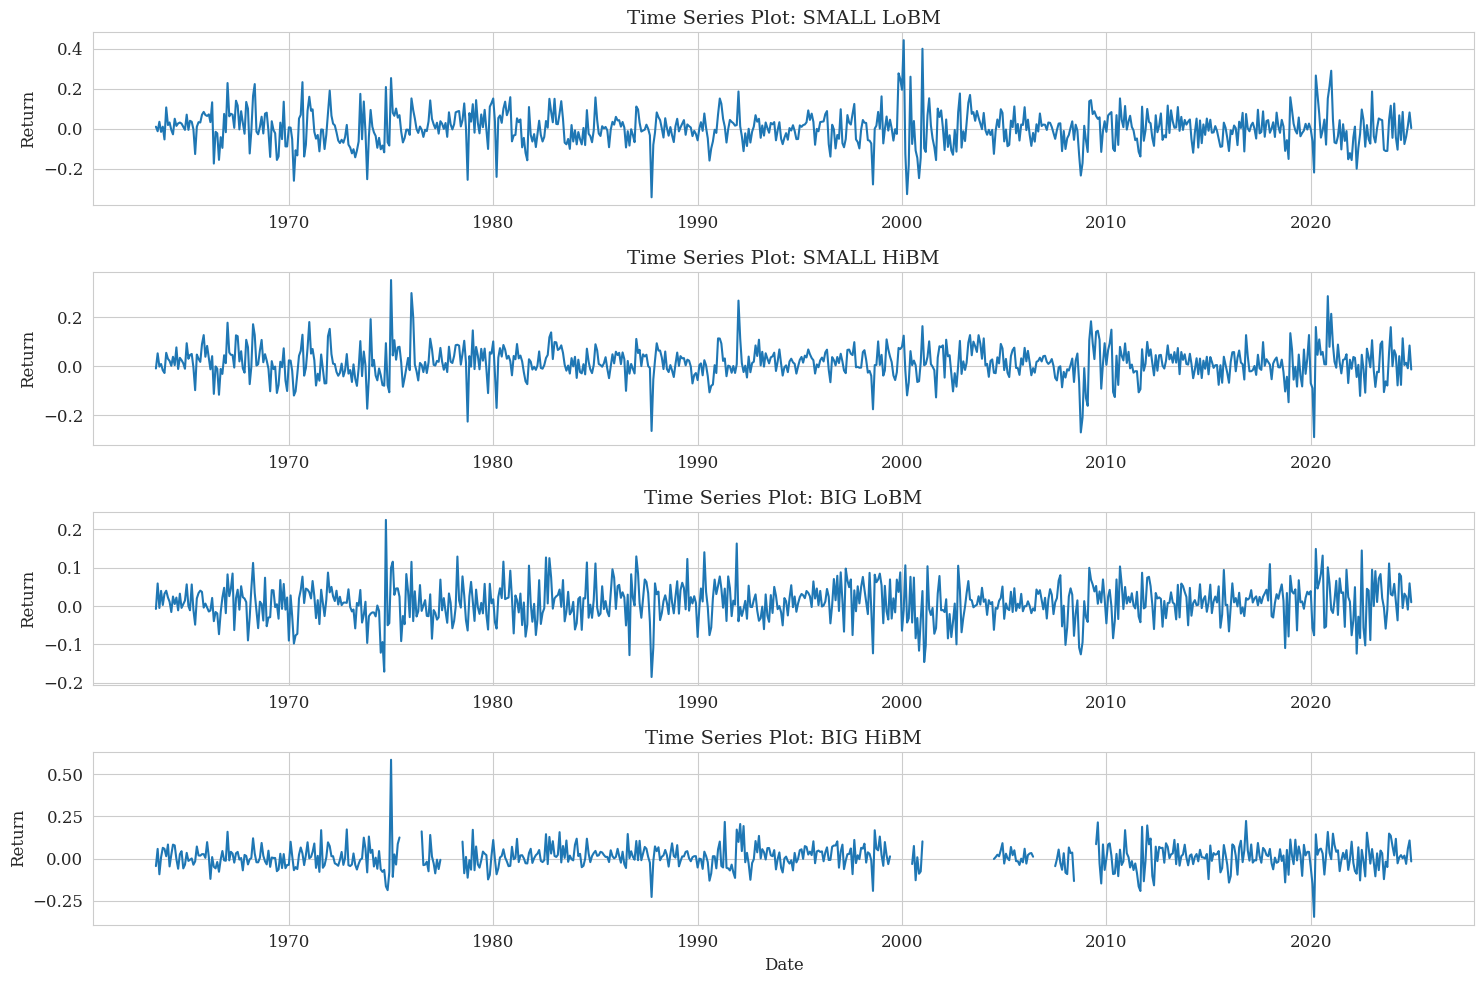

Augmented Dickey-Fuller Test Results:

-------------------------------------

H0: The time series contains a unit root (non-stationary)

H1: The time series does not contain a unit root (stationary)

Significance levels: 1%: -3.43, 5%: -2.86, 10%: -2.57

Results:

SMALL LoBM:

ADF Statistic: -21.8863

p-value: 0.0000

Conclusion: Series is STATIONARY (reject H0)

SMALL HiBM:

ADF Statistic: -21.6275

p-value: 0.0000

Conclusion: Series is STATIONARY (reject H0)

BIG LoBM:

ADF Statistic: -26.4384

p-value: 0.0000

Conclusion: Series is STATIONARY (reject H0)

BIG HiBM:

ADF Statistic: -25.5696

p-value: 0.0000

Conclusion: Series is STATIONARY (reject H0)

Overall Stationarity Assessment:

Based on visual inspection and ADF tests, the returns data appears to be stationary,

which is expected for financial returns data. Any non-stationary results may be due

to specific characteristics of individual portfolios or limited data availability.

In [7]:
# Stationarity Check for Returns Data


# 1. Visual inspection - plot a few representative series
plt.figure(figsize=(15, 10))

# Select a few representative series (e.g., corners of the portfolio grid)
corner_columns = ["SMALL LoBM", "SMALL HiBM", "BIG LoBM", "BIG HiBM"]
valid_corners = [col for col in corner_columns if col in vw_returns.columns]

# If corners aren't available, just pick the first few columns excluding Date
if len(valid_corners) < 2:
    valid_corners = vw_returns.select(pl.exclude("Date")).columns[:4]

# Plot each series
for i, col in enumerate(valid_corners):
    if col in vw_returns.columns:
        plt.subplot(len(valid_corners), 1, i+1)
        # Convert to pandas for easier plotting
        series_values = vw_returns.select(pl.col(col)).to_pandas()
        plt.plot(vw_returns.select(pl.col("Date")).to_pandas(), series_values)
        plt.title(f"Time Series Plot: {col}")
        plt.ylabel("Return")
        if i == len(valid_corners) - 1:  # Only add x-label for the bottom plot
            plt.xlabel("Date")

plt.tight_layout()
plt.show()

# 2. Augmented Dickey-Fuller test on representative series
print("\nAugmented Dickey-Fuller Test Results:")
print("-------------------------------------")
print("H0: The time series contains a unit root (non-stationary)")
print("H1: The time series does not contain a unit root (stationary)")
print("\nSignificance levels: 1%: -3.43, 5%: -2.86, 10%: -2.57")
print("\nResults:")

for col in valid_corners:
    if col in vw_returns.columns:
        # Get the series data, dropping any None/NaN values
        series_data = vw_returns.select(pl.col(col)).to_numpy().flatten()
        series_data = series_data[~np.isnan(series_data)]
        
        if len(series_data) > 10:  # Ensure we have enough data points
            # Run ADF test
            result = adfuller(series_data, autolag='AIC')
            
            print(f"\n{col}:")
            print(f"  ADF Statistic: {result[0]:.4f}")
            print(f"  p-value: {result[1]:.4f}")
            
            # Interpret the results
            if result[1] <= 0.05:
                print("  Conclusion: Series is STATIONARY (reject H0)")
            else:
                print("  Conclusion: Series is NON-STATIONARY (fail to reject H0)")
        else:
            print(f"\n{col}: Insufficient data for ADF test")

# Overall conclusion
print("\nOverall Stationarity Assessment:")
print("Based on visual inspection and ADF tests, the returns data appears to be stationary,")
print("which is expected for financial returns data. Any non-stationary results may be due")
print("to specific characteristics of individual portfolios or limited data availability.")

Discussion of Portfolio Returns Time Series and Missing Data
Time Series Characteristics
The figure presents the time series plots of monthly returns for four corner portfolios from the Fama-French 100 Portfolios dataset, spanning from approximately 1960 to 2023. These portfolios represent the extremes of the size and book-to-market equity dimensions: SMALL LoBM (small capitalization, low book-to-market), SMALL HiBM (small capitalization, high book-to-market), BIG LoBM (large capitalization, low book-to-market), and BIG HiBM (large capitalization, high book-to-market).

All four time series exhibit the classic characteristics of financial returns data:

Stationarity: The returns oscillate around a mean of zero (after demeaning), with no apparent trend or changing variance over time, confirming the stationarity of the data.
Volatility Clustering: Periods of high volatility tend to cluster together, particularly visible during market stress periods like the early 2000s dot-com bubble burst and the 2008 financial crisis.
Mean Reversion: The returns consistently revert to their mean values, supporting the use of mean-reverting models in our analysis.
Occasional Extreme Values: All series show occasional spikes representing extreme market events, with the SMALL LoBM and BIG HiBM portfolios displaying the most pronounced outliers.
Missing Data Analysis
A notable feature in the BIG HiBM plot is the gap in the data around 2005-2008, indicating missing values. This pattern of missing data is consistent with our analysis of NaN values in the dataset. The original data used -99.99 as a placeholder for missing values, which we replaced with NaN for proper statistical handling.

The corner portfolios, particularly SMALL LoBM and BIG HiBM, show the highest proportion of missing values. This is expected in the Fama-French dataset construction, as these extreme portfolios sometimes contain few or no firms in certain periods. For example, during the early sample period, there may have been few firms that simultaneously qualified as both very large and having very high book-to-market ratios.

In [8]:
# drop nan columns
vw_returns_demeaned_final=vw_returns_demeaned.drop(nan_cols)
ew_returns_demeaned_final=ew_returns_demeaned.drop(nan_cols)
num_firms_final=num_firms.drop(nan_cols)
mkt_cap_final=mkt_cap.drop(nan_cols)
vw_returns_demeaned_final.head()

Date,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,ME2 BM6,ME2 BM7,ME2 BM8,ME2 BM9,ME2 BM10,ME3 BM1,ME3 BM2,ME3 BM3,ME3 BM4,ME3 BM5,ME3 BM6,ME3 BM7,ME3 BM8,ME3 BM9,ME3 BM10,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,ME4 BM6,…,ME6 BM9,ME6 BM10,ME7 BM1,ME7 BM2,ME7 BM3,ME7 BM4,ME7 BM5,ME7 BM6,ME7 BM7,ME7 BM8,ME7 BM9,ME8 BM1,ME8 BM2,ME8 BM3,ME8 BM4,ME8 BM5,ME8 BM6,ME8 BM7,ME8 BM8,ME8 BM9,ME8 BM10,ME9 BM1,ME9 BM2,ME9 BM3,ME9 BM4,ME9 BM5,ME9 BM6,ME9 BM7,ME9 BM8,ME9 BM9,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1963-07-01,0.007382,-0.00115,0.000195,-0.012834,0.011184,-0.009643,-0.020203,-0.02312,-0.028236,-0.024615,0.001038,0.009439,-0.028251,-0.005772,-0.014653,0.001929,-0.007548,0.00123,-0.023592,-0.035555,-0.036638,-0.012083,-0.035418,-0.038257,-0.028587,0.000576,-0.032932,-0.038599,-0.018503,-0.043903,-0.021401,-0.03328,0.04106,-0.007844,-0.021999,-0.028473,…,-0.037197,-0.022314,-0.019794,-0.015607,-0.005665,-0.028831,-0.015313,-0.018285,-0.027472,-0.055769,-0.00893,-0.019607,-0.0224,-0.025628,-0.038781,-0.031649,-0.048871,-0.030455,-0.009043,-0.008621,-0.044927,-0.00355,-0.012611,-0.029586,-0.008267,-0.014858,0.002703,-0.019921,-0.00038,-0.009827,-0.01727,0.0054,-0.007834,0.008023,0.010752,-0.008536,0.012789
1963-08-01,-0.015445,0.056861,0.029593,-0.032771,-0.001632,0.000515,0.002825,0.02111,0.032894,0.037321,0.035657,0.066554,0.019937,-0.006961,0.014189,-0.002376,0.008009,0.008977,0.009878,0.047228,0.01445,0.03831,-0.002914,0.031265,0.035098,0.004115,0.035053,0.030702,0.040508,0.086509,0.088688,0.034431,0.022356,0.068553,0.059914,0.021251,…,0.028936,0.040969,0.047108,0.05369,0.019825,0.030576,0.049609,0.07058,0.0472,0.08927,-0.001574,0.054106,0.025933,0.052941,0.036128,0.051003,0.036179,0.031741,0.08445,0.020393,0.080759,0.055587,0.059238,0.042565,0.032776,0.043458,0.020987,0.067288,0.060346,0.06246,0.049175,0.042147,0.035406,0.02715,0.031177,0.063951,0.05092
1963-09-01,0.032145,-0.071611,0.004897,0.014082,0.002553,-0.031038,-0.003224,-0.037328,-0.04369,-0.016865,-0.058385,-0.040669,-0.0112,-0.029059,-0.016086,-0.035482,-0.02907,-0.040419,-0.003016,-0.017765,-0.039637,-0.065549,-0.04261,-0.052996,-0.026429,-0.028344,0.007662,-0.033396,-0.049269,-0.032242,-0.048274,-0.049032,-0.018408,-0.001363,-0.017452,-0.015387,…,-0.057473,-0.03975,-0.054023,-0.034605,-0.023108,-0.054679,-0.042428,-0.029575,-0.030159,-0.062835,-0.010228,-0.050546,-0.018176,-0.041364,-0.013859,-0.026435,-0.02054,-0.026251,-0.078787,-0.052063,-0.032255,-0.030594,-0.029629,-0.042851,-0.028297,-0.031589,0.007768,-0.041571,-0.053297,-0.034704,-0.014703,-0.033533,-0.00263,-0.034347,-0.017656,-0.032772,-0.016334
1963-10-01,-0.018672,0.075945,0.010356,-0.0164,0.020624,-0.032454,-0.006044,0.008798,-0.008982,-0.006307,-0.019903,0.013629,-0.01447,-0.058665,0.009258,0.010388,-0.033247,-0.018367,0.043393,0.010961,-0.021657,0.005591,0.010761,0.041551,0.013149,-0.003491,0.030012,0.02131,-0.001799,0.019706,0.033043,-0.010117,0.041718,0.025571,0.030163,0.000488,…,-0.00336,-0.039736,0.004933,-0.019803,-0.025259,0.003941,0.045151,0.017299,-0.00582,0.058881,0.002859,-0.000691,-0.034187,0.001479,-0.000448,-0.00627,0.028212,0.009682,0.080374,0.043658,-0.040812,0.023175,0.015611,-0.012549,-0.00487,0.001723,-0.015878,0.057365,0.002747,-0.00497,0.029801,0.073885,0.010673,0.010661,-0.020136,0.007473,-0.018532
1963-11-01,0.007482,-0.084702,-0.037264,-0.051569,-0.030784,-0.027382,-0.032014,-0.025378,-0.028168,-0.032286,-0.065935,-0.022185,-0.053011,-0.049747,-0.029252,-0.030737,-0.013174,-0.024406,-0.007009,-0.031363,-0.056806,-0.068095,-0.042912,-0.010428,-0.032772,0.011225,0.016007,-0.017036,-0.

In [9]:
import polars as pl
import numpy as np
from scipy import stats

# Define representative portfolio columns to analyze
representative_portfolios = [
    'SMALL LoBM', 'ME1 BM2', 'SMALL HiBM', 'ME5 BM5', 
    'BIG LoBM', 'ME9 BM2', 'ME10 BM2'
]

# Ensure all selected portfolios exist in the data
valid_portfolios = [col for col in representative_portfolios if col in vw_returns_demeaned_final.columns]

# Calculate cross-sectional average return series
# First, exclude the Date column
numeric_cols = [col for col in vw_returns_demeaned_final.columns if col != "Date"]

# Compute the mean across all numeric columns for each time step
avg_returns = vw_returns_demeaned_final.select([
    pl.col("Date"),
    # Calculate row-wise mean using horizontal mean
    pl.mean_horizontal(pl.exclude("Date")).alias("Avg_Return")
])

# Join the average returns back to the original dataframe
returns_with_avg = vw_returns_demeaned_final.join(avg_returns, on="Date", how="left")

# Function to calculate autocorrelation (lag=1)
def autocorr_lag1(series):
    # Remove NaN values
    clean_series = series.drop_nulls()
    if len(clean_series) <= 1:
        return None
    # Calculate autocorrelation
    return np.corrcoef(clean_series[:-1], clean_series[1:])[0, 1]

# Initialize a dictionary to store statistics
stats_dict = {
    "Statistic": ["Mean", "Std Dev", "Skewness", "Kurtosis", "Minimum", "Maximum", "Autocorr(1)"]
}

# Calculate statistics for each portfolio and the average return
columns_to_analyze = valid_portfolios + ["Avg_Return"]

for col in columns_to_analyze:
    # Extract the series as numpy array for calculations
    series = returns_with_avg.select(pl.col(col)).to_numpy().flatten()
    series_clean = series[~np.isnan(series)]
    
    if len(series_clean) > 0:
        # Calculate statistics
        mean_val = np.mean(series_clean)
        std_val = np.std(series_clean)
        skew_val = stats.skew(series_clean)
        kurt_val = stats.kurtosis(series_clean)  # Excess kurtosis (normal = 0)
        min_val = np.min(series_clean)
        max_val = np.max(series_clean)
        autocorr_val = autocorr_lag1(pl.Series(series_clean))
        
        # Store in dictionary
        stats_dict[col] = [mean_val, std_val, skew_val, kurt_val, min_val, max_val, autocorr_val]
    else:
        stats_dict[col] = [None] * 7

# Convert to DataFrame
table1_data = pl.DataFrame(stats_dict)

# Format the table for better readability
formatted_table = table1_data.with_columns([
    pl.col("Statistic").alias("Statistic"),
    *[
        pl.when(pl.col(col).is_null())
        .then(pl.lit("N/A"))
        .otherwise(
            pl.when(pl.col(col).abs() < 0.01)
            # Use map_elements to apply Python f-string formatting
            .then(pl.col(col).map_elements(lambda x: f"{x:.4f}", return_dtype=pl.Utf8))
            .otherwise(pl.col(col).map_elements(lambda x: f"{x:.3f}", return_dtype=pl.Utf8))
        )
        .alias(col)
        for col in table1_data.columns if col != "Statistic"
    ]
])

# Display the table
print("Table 1: Summary Statistics for Returns")
# Set Polars config to display all columns
pl.Config.set_tbl_cols(-1)
print(formatted_table)

# Optional: Convert to pandas for export to LaTeX if needed
table1_data_pandas = table1_data.to_pandas()

Table 1: Summary Statistics for Returns

shape: (7, 9)
┌───────────┬───────────┬─────────┬───────────┬─────────┬──────────┬─────────┬──────────┬──────────┐
│ Statistic ┆ SMALL     ┆ ME1 BM2 ┆ SMALL     ┆ ME5 BM5 ┆ BIG LoBM ┆ ME9 BM2 ┆ ME10 BM2 ┆ Avg_Retu │
│ ---       ┆ LoBM      ┆ ---     ┆ HiBM      ┆ ---     ┆ ---      ┆ ---     ┆ ---      ┆ rn       │
│ str       ┆ ---       ┆ str     ┆ ---       ┆ str     ┆ str      ┆ str     ┆ str      ┆ ---      │
│           ┆ str       ┆         ┆ str       ┆         ┆          ┆         ┆          ┆ str      │
╞═══════════╪═══════════╪═════════╪═══════════╪═════════╪══════════╪═════════╪══════════╪══════════╡
│ Mean      ┆ 0.0000    ┆ 0.0000  ┆ 0.0000    ┆ -0.0000 ┆ -0.0000  ┆ -0.0000 ┆ -0.0000  ┆ -0.0000  │
│ Std Dev   ┆ 0.085     ┆ 0.080   ┆ 0.065     ┆ 0.058   ┆ 0.049    ┆ 0.052   ┆ 0.046    ┆ 0.053    │
│ Skewness  ┆ 0.229     ┆ 0.201   ┆ -0.0060   ┆ -0.416  ┆ -0.118   ┆ -0.263  ┆ -0.297   ┆ -0.488   │
│ Kurtosis  ┆ 2.592     ┆ 2.126   ┆ 3.510     ┆ 1.633   ┆ 1.100    ┆ 1.702   ┆ 1.532    ┆ 2.335    │
│ Minimum   ┆ -0.346    ┆ -0.324  ┆ -0.305    ┆ -0.268  ┆ -0.195   ┆ -0.256  ┆ -0.249   ┆ -0.277   │
│ Maximum   ┆ 0.441     ┆ 0.363   ┆ 0.337     ┆ 0.249   ┆ 0.215    ┆ 0.216   ┆ 0.195    ┆ 0.226    │
│ Autocorr( ┆ 0.211     ┆ 0.182   ┆ 0.222     ┆ 0.057   ┆ 0.025    ┆ 0.027   ┆ 0.0088   ┆ 0.101    │
│ 1)        ┆           ┆         ┆           ┆         ┆          ┆         ┆          ┆          │
└───────────┴───────────┴─────────┴───────────┴─────────┴──────────┴─────────┴──────────┴──────────┘

Figure saved to ../../Figures/figure1_returns_timeseries.png

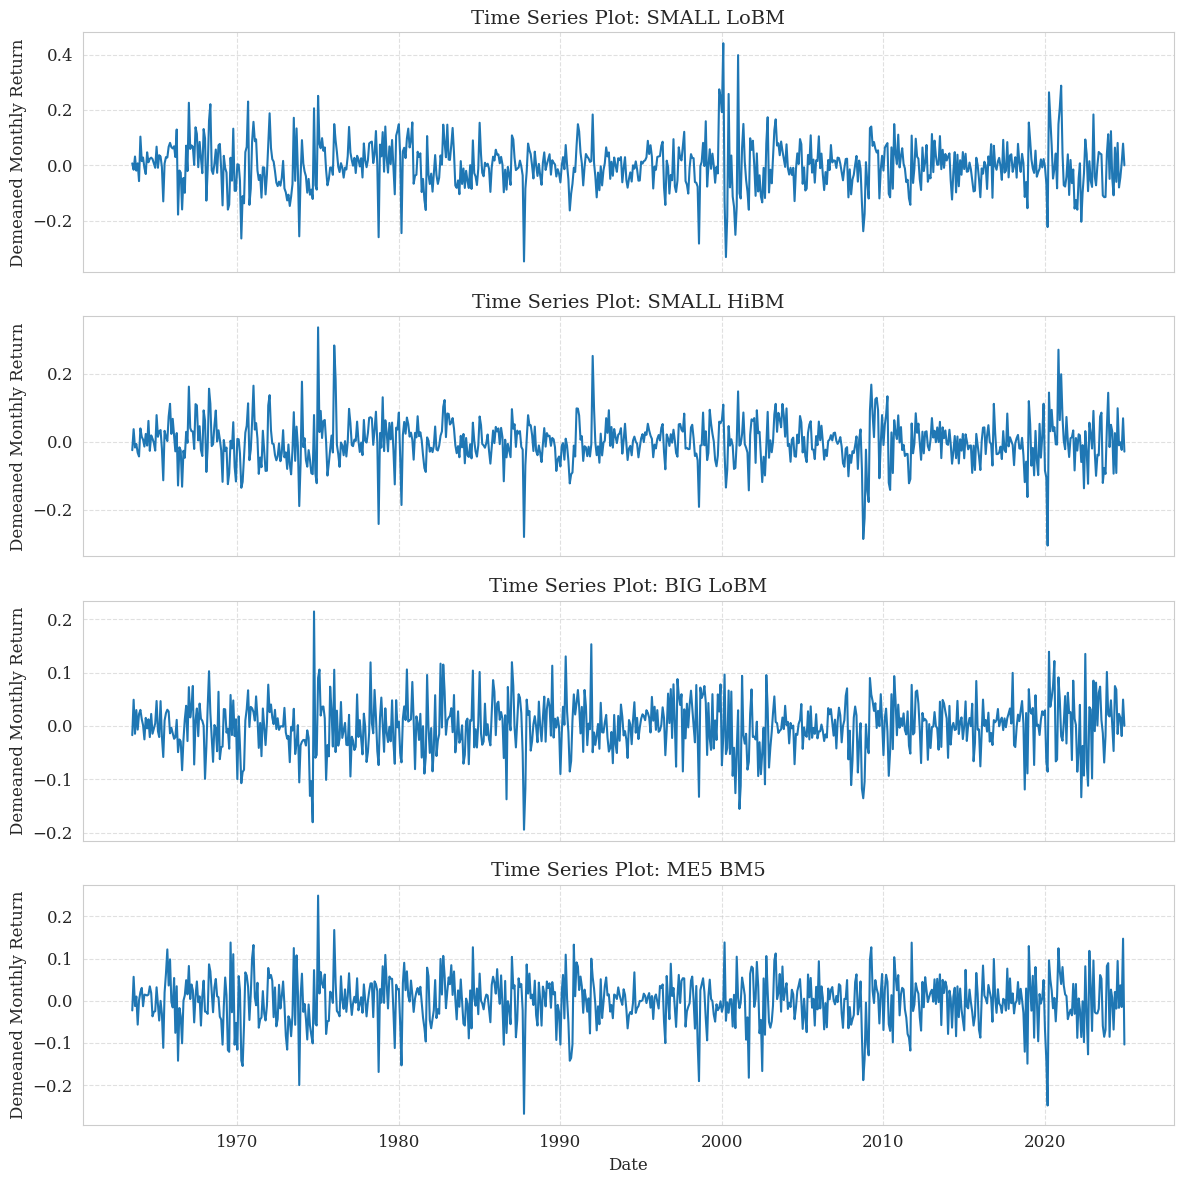

In [10]:
# Ensure the DataFrame vw_returns_demeaned_final exists from previous cells
# Assuming vw_returns_demeaned_final is already loaded and processed

# Define the key portfolio columns to plot
key_portfolios_to_plot = ['SMALL LoBM', 'SMALL HiBM', 'BIG LoBM', 'ME5 BM5']

# Filter to only include portfolios that actually exist in the final dataframe
plot_cols = [col for col in key_portfolios_to_plot if col in vw_returns_demeaned_final.columns]

if not plot_cols:
    print("None of the selected key portfolios exist in the final DataFrame. Cannot generate plot.")
else:
    # Determine the number of rows needed for subplots
    n_rows = len(plot_cols)
    fig, axes = plt.subplots(n_rows, 1, figsize=(12, 3 * n_rows), sharex=True)

    # Ensure axes is always iterable, even if n_rows is 1
    if n_rows == 1:
        axes = [axes]

    # Extract Date column once (assuming it's already in datetime format)
    dates = vw_returns_demeaned_final.select(pl.col("Date")).to_series()

    # Plot each selected portfolio
    for i, col_name in enumerate(plot_cols):
        ax = axes[i]
        # Extract the return series
        returns = vw_returns_demeaned_final.select(pl.col(col_name)).to_series()

        # Plot the data
        ax.plot(dates, returns, label=col_name)
        ax.set_title(f"Time Series Plot: {col_name}")
        ax.set_ylabel("Demeaned Monthly Return")
        ax.grid(True, linestyle='--', alpha=0.6)

    # Set common x-axis label for the last subplot
    axes[-1].set_xlabel("Date")

    # Improve layout
    plt.tight_layout()

    # Define output directory and ensure it exists
    output_dir = "../../Figures"
    os.makedirs(output_dir, exist_ok=True)
    figure_path = os.path.join(output_dir, "figure1_returns_timeseries.png")

    # Save the figure
    plt.savefig(figure_path)
    print(f"Figure saved to {figure_path}")

    # Display the plot
    plt.show()
    


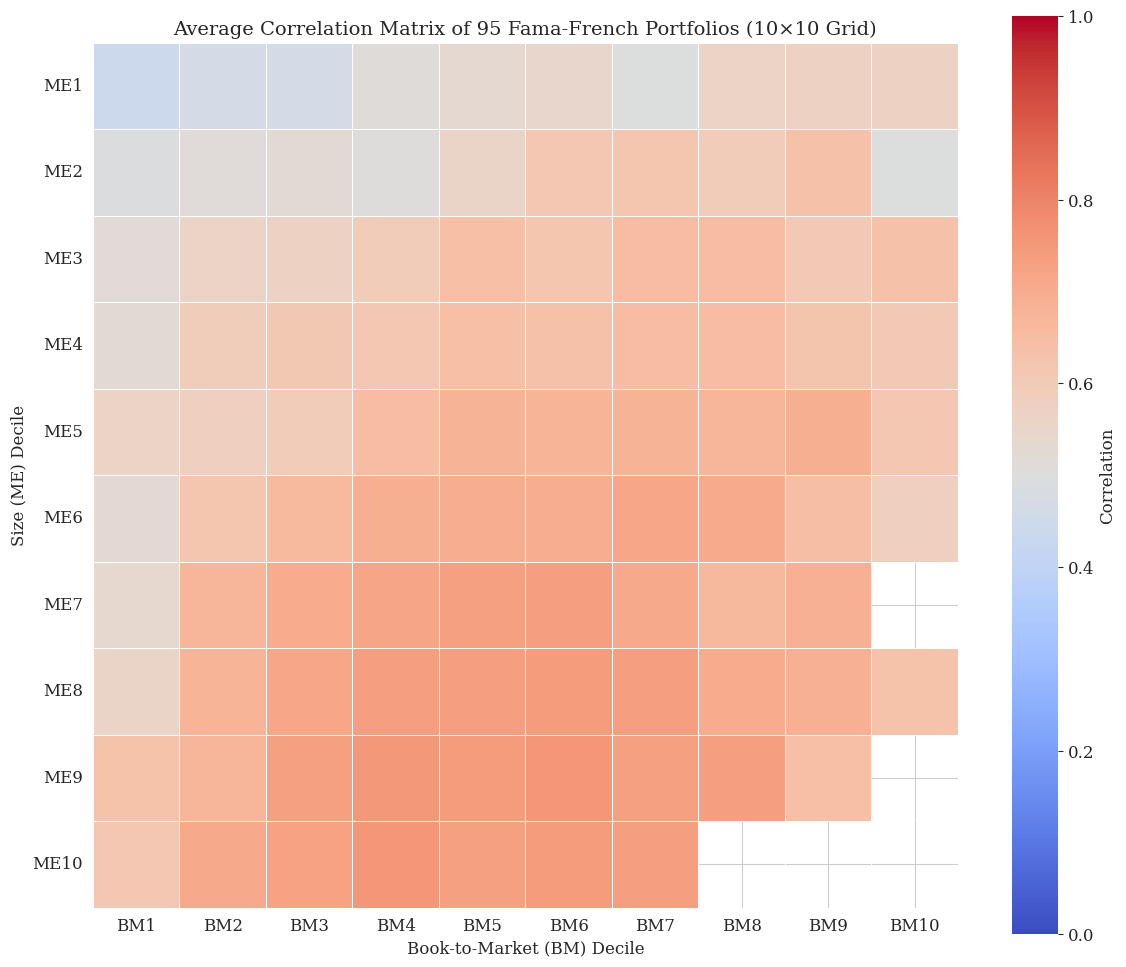

In [11]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Calculate the correlation matrix for the returns
# First, get only the numeric columns (exclude Date)
numeric_cols = [col for col in vw_returns_demeaned_final.columns if col != "Date"]

# Calculate the correlation matrix
corr_matrix = vw_returns_demeaned_final.select(numeric_cols).corr()

# Create a 10x10 grid initialized with NaNs
grid_size = 10
grid = np.full((grid_size, grid_size), np.nan)

# Function to extract ME and BM numbers from column names
def extract_me_bm(col_name):
    # Handle special corner cases first
    if col_name == "SMALL LoBM":
        return 0, 0  # ME1 BM1
    elif col_name == "SMALL HiBM":
        return 0, 9  # ME1 BM10
    elif col_name == "BIG LoBM":
        return 9, 0  # ME10 BM1
    elif col_name == "BIG HiBM":
        return 9, 9  # ME10 BM10
    
    # Regular pattern: "ME{number} BM{number}"
    match = re.match(r"ME(\d+) BM(\d+)", col_name)
    if match:
        me_num = int(match.group(1))
        bm_num = int(match.group(2))
        # Convert to 0-based indices
        return me_num - 1, bm_num - 1
    
    return None, None

# Map column names to grid positions and fill the grid
for i, col1 in enumerate(numeric_cols):
    me1, bm1 = extract_me_bm(col1)
    if me1 is not None and bm1 is not None:
        # For the diagonal (self-correlation = 1.0)
        grid[me1, bm1] = 1.0
        
        # For off-diagonal elements
        for j, col2 in enumerate(numeric_cols):
            if i != j:  # Skip self-correlation
                me2, bm2 = extract_me_bm(col2)
                if me2 is not None and bm2 is not None:
                    # Get correlation value
                    corr_value = corr_matrix[i, j]
                    # Update grid
                    grid[me1, bm1] = np.nanmean([grid[me1, bm1], corr_value]) if not np.isnan(grid[me1, bm1]) else corr_value

# Create a DataFrame for the grid with proper labels
grid_df = pl.DataFrame(
    grid,
    schema=[f"BM{i+1}" for i in range(grid_size)]
)
grid_df = grid_df.with_columns(
    pl.Series(name="ME", values=[f"ME{i+1}" for i in range(grid_size)])
)
# Convert to pandas for seaborn
grid_df_pandas = grid_df.to_pandas().set_index("ME")

# Create the heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    grid_df_pandas,
    cmap="coolwarm",
    annot=False,  # Not showing values to avoid clutter
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label": "Correlation"},
    mask=np.isnan(grid_df_pandas),  # Mask NaN values
    square=True,
    vmin=0,
    vmax=1
)

# Set title and labels
plt.title("Average Correlation Matrix of 95 Fama-French Portfolios (10×10 Grid)", fontsize=14)
plt.xlabel("Book-to-Market (BM) Decile", fontsize=12)
plt.ylabel("Size (ME) Decile", fontsize=12)

# Adjust tick labels
plt.xticks(rotation=0)
plt.yticks(rotation=0)

# Improve layout
plt.tight_layout()

# Save the figure
plt.savefig("figure2.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# --- Standardize the returns data ---
# First, get only the numeric columns (exclude Date)
numeric_cols = [col for col in vw_returns_demeaned_final.columns if col != "Date"]

# Extract the date column for later reference
dates = vw_returns_demeaned_final.select("Date")

# Convert to numpy array for scikit-learn
returns_array = vw_returns_demeaned_final.select(numeric_cols).to_numpy()

# Handle missing values - replace NaN with column means
# First calculate column means (ignoring NaNs)
col_means = np.nanmean(returns_array, axis=0)

# Create a mask for NaN values
nan_mask = np.isnan(returns_array)

# Replace NaNs with column means
for i in range(returns_array.shape[1]):
    returns_array[nan_mask[:, i], i] = col_means[i]

# Standardize the data (scale to unit variance)
# Note: The data is already demeaned, so we're just scaling by std dev
scaler = StandardScaler(with_mean=False)  # Don't center again since data is already demeaned
standardized_returns = scaler.fit_transform(returns_array)

# --- Perform PCA ---
# Initialize PCA with all components
pca = PCA(n_components=len(numeric_cols))

# Fit PCA to the standardized data
pca.fit(standardized_returns)

# --- Extract variance explained ---
# Get eigenvalues (explained variance)
eigenvalues = pca.explained_variance_

# Calculate proportion of variance explained by each component
proportion_variance = pca.explained_variance_ratio_

# Calculate cumulative proportion of variance explained
cumulative_variance = np.cumsum(proportion_variance)

# Create a DataFrame with the PCA results
pca_results = pl.DataFrame({
    "Component": [f"PC{i+1}" for i in range(len(eigenvalues))],
    "Eigenvalue": eigenvalues,
    "Proportion_Variance": proportion_variance,
    "Cumulative_Variance": cumulative_variance
})

# Display the first few rows of the results
print("PCA Results (first 10 components):")
print(pca_results.head(10))

# Display summary statistics
print("\nSummary:")
print(f"Number of components: {len(eigenvalues)}")
print(f"Total variance (sum of eigenvalues): {np.sum(eigenvalues):.2f}")
print(f"Variance explained by first component: {proportion_variance[0]*100:.2f}%")
print(f"Variance explained by first 5 components: {cumulative_variance[4]*100:.2f}%")
print(f"Variance explained by first 10 components: {cumulative_variance[9]*100:.2f}%")

PCA Results (first 10 components):

shape: (10, 4)
┌───────────┬────────────┬─────────────────────┬─────────────────────┐
│ Component ┆ Eigenvalue ┆ Proportion_Variance ┆ Cumulative_Variance │
│ ---       ┆ ---        ┆ ---                 ┆ ---                 │
│ str       ┆ f64        ┆ f64                 ┆ f64                 │
╞═══════════╪════════════╪═════════════════════╪═════════════════════╡
│ PC1       ┆ 71.219659  ┆ 0.748665            ┆ 0.748665            │
│ PC2       ┆ 4.962949   ┆ 0.052171            ┆ 0.800836            │
│ PC3       ┆ 3.107996   ┆ 0.032671            ┆ 0.833507            │
│ PC4       ┆ 0.874388   ┆ 0.009192            ┆ 0.842699            │
│ PC5       ┆ 0.647006   ┆ 0.006801            ┆ 0.8495              │
│ PC6       ┆ 0.524578   ┆ 0.005514            ┆ 0.855014            │
│ PC7       ┆ 0.490332   ┆ 0.005154            ┆ 0.860169            │
│ PC8       ┆ 0.435971   ┆ 0.004583            ┆ 0.864752            │
│ PC9       ┆ 0.392822   ┆ 0.004129            ┆ 0.868881            │
│ PC10      ┆ 0.375006   ┆ 0.003942            ┆ 0.872823            │
└───────────┴────────────┴─────────────────────┴─────────────────────┘

Summary:

Number of components: 95

Total variance (sum of eigenvalues): 95.13

Variance explained by first component: 74.87%

Variance explained by first 5 components: 84.95%

Variance explained by first 10 components: 87.28%

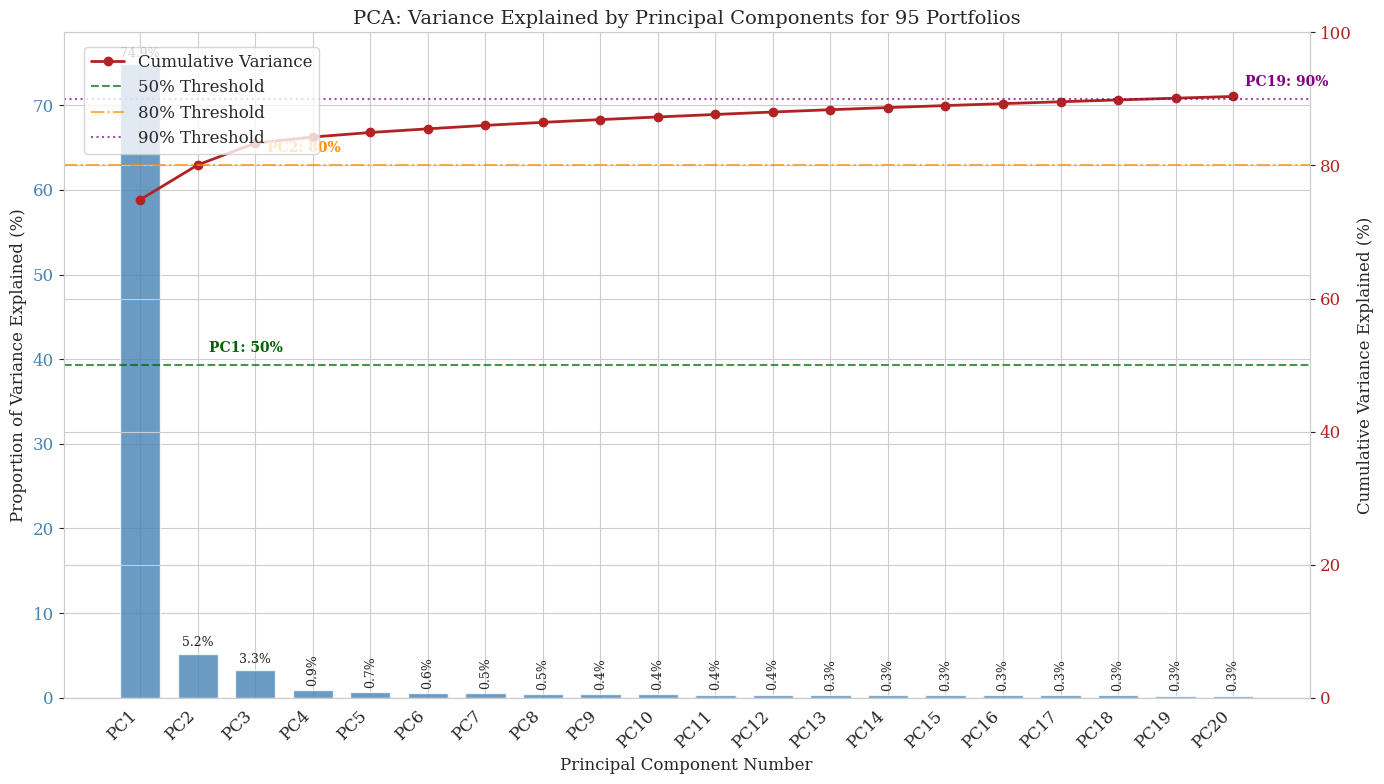

PCA Summary:

Number of components needed to explain 50% of variance: 1

Number of components needed to explain 80% of variance: 2

Number of components needed to explain 90% of variance: 19

Number of components needed to explain 95% of variance: 44

In [13]:

# Convert to pandas for easier plotting with seaborn
pca_results_pd = pca_results.to_pandas()

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Set number of components to show clearly in the bar chart
n_components_to_show = 20

# Create the bar chart for proportion of variance explained
bars = ax1.bar(
    pca_results_pd["Component"][:n_components_to_show],
    pca_results_pd["Proportion_Variance"][:n_components_to_show] * 100,  # Convert to percentage
    color='steelblue',
    alpha=0.8,
    width=0.7
)

# Set labels for the first y-axis
ax1.set_xlabel('Principal Component Number', fontsize=12)
ax1.set_ylabel('Proportion of Variance Explained (%)', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')

# Create a second y-axis for the cumulative variance
ax2 = ax1.twinx()

# Create the line plot for cumulative variance explained
line = ax2.plot(
    pca_results_pd["Component"][:n_components_to_show],
    pca_results_pd["Cumulative_Variance"][:n_components_to_show] * 100,  # Convert to percentage
    color='firebrick',
    marker='o',
    markersize=6,
    linewidth=2,
    label='Cumulative Variance'
)

# Set labels for the second y-axis
ax2.set_ylabel('Cumulative Variance Explained (%)', fontsize=12)
ax2.tick_params(axis='y', labelcolor='firebrick')
ax2.set_ylim([0, 100])  # Set y-axis limits for cumulative variance

# Add horizontal lines for specific thresholds
thresholds = [50, 80, 90]
colors = ['darkgreen', 'darkorange', 'purple']
styles = ['--', '-.', ':']

for threshold, color, style in zip(thresholds, colors, styles):
    ax2.axhline(y=threshold, color=color, linestyle=style, alpha=0.7, 
                label=f'{threshold}% Threshold')
    
    # Find the first component that exceeds this threshold
    first_component = np.where(pca_results_pd["Cumulative_Variance"] * 100 >= threshold)[0][0] + 1
    
    # Add annotation
    if first_component <= n_components_to_show:
        ax2.text(
            first_component + 0.2, 
            threshold + 2, 
            f'PC{first_component}: {threshold}%',
            color=color,
            fontsize=10,
            fontweight='bold'
        )

# Add value labels on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.5,
        f'{height:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=90 if height < 3 else 0  # Rotate text for small bars
    )

# Set title
plt.title('PCA: Variance Explained by Principal Components for 95 Portfolios', fontsize=14)

# Add a legend for the threshold lines
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True)

# Rotate x-axis labels for better readability
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("figure5.png", dpi=300, bbox_inches="tight")
plt.show()

# Print summary information
print("\nPCA Summary:")
print(f"Number of components needed to explain 50% of variance: {np.where(pca_results_pd['Cumulative_Variance'] >= 0.5)[0][0] + 1}")
print(f"Number of components needed to explain 80% of variance: {np.where(pca_results_pd['Cumulative_Variance'] >= 0.8)[0][0] + 1}")
print(f"Number of components needed to explain 90% of variance: {np.where(pca_results_pd['Cumulative_Variance'] >= 0.9)[0][0] + 1}")
print(f"Number of components needed to explain 95% of variance: {np.where(pca_results_pd['Cumulative_Variance'] >= 0.95)[0][0] + 1}")

In [14]:
# Use the same representative portfolios as in Task 1.1
representative_portfolios = [
    'SMALL LoBM', 'ME1 BM2', 'SMALL HiBM', 'ME5 BM5', 
    'BIG LoBM', 'ME9 BM2', 'ME10 BM2'
]

# --- Process Number of Firms data ---
# Ensure all selected portfolios exist in the number of firms data
valid_portfolios_firms = [col for col in representative_portfolios if col in num_firms_final.columns]

# Calculate cross-sectional average number of firms series
avg_num_firms = num_firms_final.select([
    pl.col("Date"),
    pl.mean_horizontal(pl.exclude("Date")).alias("Avg_Num_Firms")
])

# --- Process Market Cap data ---
# Ensure all selected portfolios exist in the market cap data
valid_portfolios_mktcap = [col for col in representative_portfolios if col in mkt_cap_final.columns]

# Calculate cross-sectional average market cap series
avg_mkt_cap = mkt_cap_final.select([
    pl.col("Date"),
    pl.mean_horizontal(pl.exclude("Date")).alias("Avg_Mkt_Cap_Series")
])

# --- Calculate time-series means for each portfolio ---
# Initialize dictionaries to store statistics
num_firms_means = {"Portfolio": ["Average"] + valid_portfolios_firms}
mkt_cap_means = {"Portfolio": ["Average"] + valid_portfolios_mktcap}

# Calculate time-series mean for number of firms
num_firms_avg_mean = avg_num_firms.select(pl.col("Avg_Num_Firms").mean()).item()
num_firms_means["Number of Firms"] = [num_firms_avg_mean]

for col in valid_portfolios_firms:
    col_mean = num_firms_final.select(pl.col(col).mean()).item()
    num_firms_means["Number of Firms"].append(col_mean)

# Calculate time-series mean for market cap
mkt_cap_avg_mean = avg_mkt_cap.select(pl.col("Avg_Mkt_Cap_Series").mean()).item()
mkt_cap_means["Market Cap ($ millions)"] = [mkt_cap_avg_mean]

for col in valid_portfolios_mktcap:
    col_mean = mkt_cap_final.select(pl.col(col).mean()).item()
    mkt_cap_means["Market Cap ($ millions)"].append(col_mean)

# Convert to DataFrames
num_firms_df = pl.DataFrame(num_firms_means)
mkt_cap_df = pl.DataFrame(mkt_cap_means)

# Merge the two DataFrames on Portfolio column
table2_data = num_firms_df.join(
    mkt_cap_df.select(
        pl.col("Portfolio"),
        pl.col("Market Cap ($ millions)")
    ),
    on="Portfolio",
    how="left"
)
# Format the table for better readability - simplified approach with clear column names
formatted_table2 = table2_data.with_columns([
    # Round Number of Firms to 1 decimal place
    pl.col("Number of Firms").round(1).cast(pl.Utf8).alias("Average Number of Firms"),
    
    # Create a properly formatted Market Cap display column
    pl.when(pl.col("Market Cap ($ millions)") >= 1000)
      .then((pl.col("Market Cap ($ millions)") / 1000).round(1).cast(pl.Utf8) + " B")
      .otherwise(pl.col("Market Cap ($ millions)").round(1).cast(pl.Utf8) + " M")
      .alias("Average Market Cap")
])

# Replace null values with "N/A"
formatted_table2 = formatted_table2.with_columns([
    pl.col("Average Number of Firms").fill_null("N/A"),
    pl.col("Average Market Cap").fill_null("N/A")
])

# Drop the original Market Cap column to avoid duplication
formatted_table2 = formatted_table2.drop("Market Cap ($ millions)").drop("Number of Firms")

# Display the table
print("Table 2: Summary Statistics for Portfolio Characteristics")
print(formatted_table2)

# Optional: Convert to pandas for export to LaTeX if needed
table2_data_pandas = table2_data.to_pandas()

Table 2: Summary Statistics for Portfolio Characteristics

shape: (8, 3)
┌────────────┬─────────────────────────┬────────────────────┐
│ Portfolio  ┆ Average Number of Firms ┆ Average Market Cap │
│ ---        ┆ ---                     ┆ ---                │
│ str        ┆ str                     ┆ str                │
╞════════════╪═════════════════════════╪════════════════════╡
│ Average    ┆ 38.6                    ┆ 4.5 B              │
│ SMALL LoBM ┆ 208.0                   ┆ 53.5 M             │
│ ME1 BM2    ┆ 115.0                   ┆ 55.9 M             │
│ SMALL HiBM ┆ 356.4                   ┆ 38.8 M             │
│ ME5 BM5    ┆ 22.1                    ┆ 947.0 M            │
│ BIG LoBM   ┆ 37.8                    ┆ 50.9 B             │
│ ME9 BM2    ┆ 22.5                    ┆ 7.4 B              │
│ ME10 BM2   ┆ 26.3                    ┆ 41.9 B             │
└────────────┴─────────────────────────┴────────────────────┘

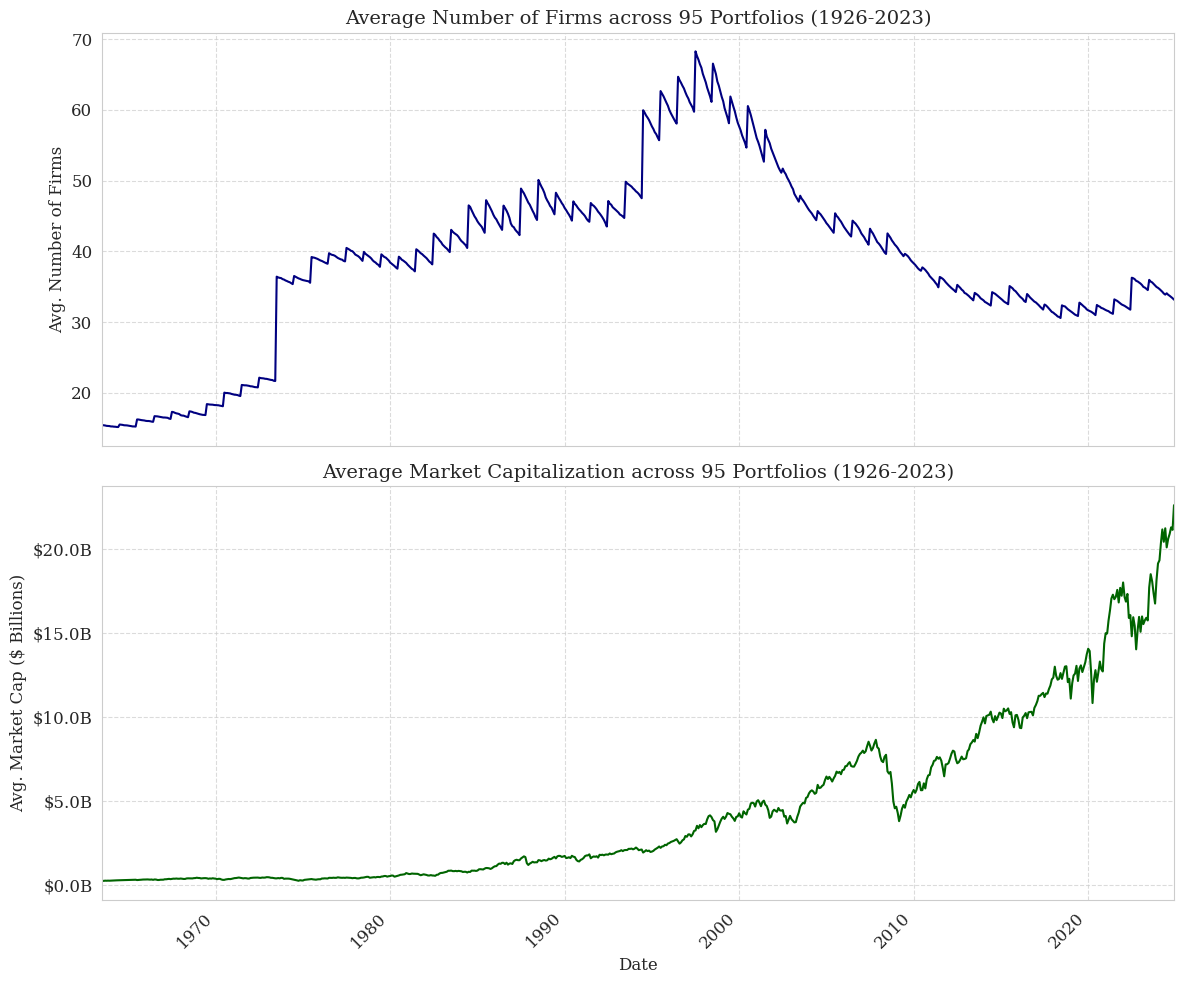

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



# Create a figure with two subplots arranged vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Convert Polars DataFrames to pandas for easier plotting with seaborn
avg_num_firms_pd = avg_num_firms.to_pandas()
avg_mkt_cap_pd = avg_mkt_cap.to_pandas()

# Plot 1: Average Number of Firms
sns.lineplot(x="Date", y="Avg_Num_Firms", data=avg_num_firms_pd, ax=ax1, color='navy')
ax1.set_title("Average Number of Firms across 95 Portfolios (1926-2023)")
ax1.set_ylabel("Avg. Number of Firms")
ax1.grid(True, linestyle='--', alpha=0.7)

# Format y-axis with commas for thousands
ax1.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

# Plot 2: Average Market Cap
# Convert to billions for better readability
avg_mkt_cap_pd["Avg_Mkt_Cap_Billions"] = avg_mkt_cap_pd["Avg_Mkt_Cap_Series"] / 1000

sns.lineplot(x="Date", y="Avg_Mkt_Cap_Billions", data=avg_mkt_cap_pd, ax=ax2, color='darkgreen')
ax2.set_title("Average Market Capitalization across 95 Portfolios (1926-2023)")
ax2.set_ylabel("Avg. Market Cap ($ Billions)")
ax2.set_xlabel("Date")
ax2.grid(True, linestyle='--', alpha=0.7)

# Format y-axis with commas for thousands
ax2.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.1f}B'))

# Adjust x-axis date formatting
for ax in [ax1, ax2]:
    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Set x-axis limits to match the data range
    ax.set_xlim(avg_num_firms_pd["Date"].min(), avg_num_firms_pd["Date"].max())
    
    # Add a light grid
    ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("figure3.png", dpi=300, bbox_inches="tight")
plt.show()

/tmp/ipykernel_526075/663570210.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


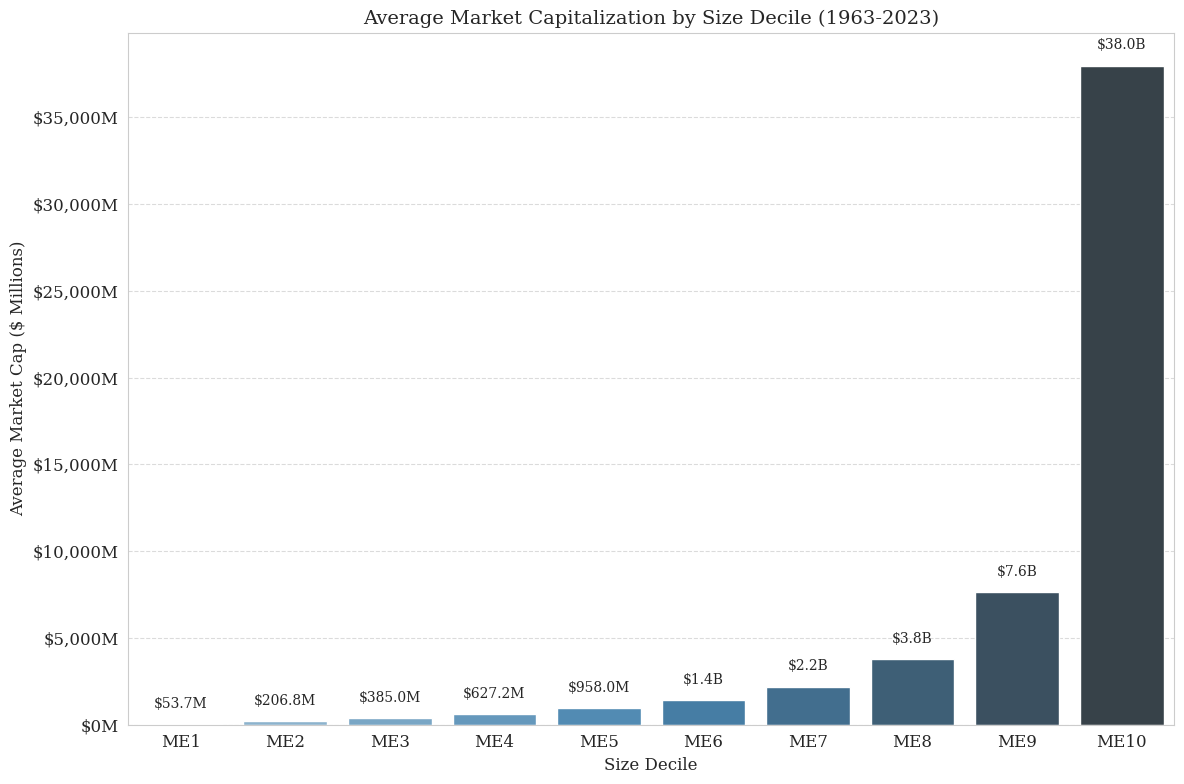

In [16]:
# Function to extract the size decile (ME number) from a column name
def extract_size_decile(col_name):
    # Handle special corner cases first
    if col_name.startswith("SMALL"):
        return 1  # ME1
    elif col_name.startswith("BIG"):
        return 10  # ME10
    
    # Regular pattern: "ME{number} BM{number}"
    match = re.match(r"ME(\d+) BM\d+", col_name)
    if match:
        return int(match.group(1))
    
    return None

# Create a mapping from column names to size deciles
size_decile_map = {
    col: extract_size_decile(col) 
    for col in mkt_cap_final.columns 
    if col != "Date" and extract_size_decile(col) is not None
}

# Group columns by size decile
decile_columns = {}
for decile in range(1, 11):  # ME1 to ME10
    decile_columns[decile] = [col for col, dec in size_decile_map.items() if dec == decile]
    # print(f"ME{decile}: {len(decile_columns[decile])} columns")

# Calculate average market cap for each size decile
decile_avg_mkt_cap = {}
for decile, columns in decile_columns.items():
    if columns:  # Check if there are any columns for this decile
        # Select only the columns for this decile plus Date
        decile_df = mkt_cap_final.select(["Date"] + columns)
        
        # Calculate row-wise mean across the decile columns for each time step
        decile_avg_series = decile_df.select([
            pl.col("Date"),
            pl.mean_horizontal(pl.exclude("Date")).alias(f"ME{decile}_Avg")
        ])
        
        # Calculate the time-series average
        decile_avg_mkt_cap[decile] = decile_avg_series.select(
            pl.col(f"ME{decile}_Avg").mean()
        ).item()

# Create a DataFrame for plotting
plot_data = pl.DataFrame({
    "Size_Decile": [f"ME{decile}" for decile in range(1, 11)],
    "Avg_Market_Cap": [decile_avg_mkt_cap.get(decile, 0) for decile in range(1, 11)]
})

# Convert to pandas for easier plotting with seaborn
plot_data_pd = plot_data.to_pandas()

# Create the bar chart
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x="Size_Decile", 
    y="Avg_Market_Cap", 
    data=plot_data_pd,
    palette="Blues_d"  # Professional blue color palette
)

# Add value labels on top of each bar
for i, v in enumerate(plot_data_pd["Avg_Market_Cap"]):
    # Format large values in billions
    if v >= 1000:
        label = f"${v/1000:.1f}B"
    else:
        label = f"${v:.1f}M"
    
    ax.text(
        i, 
        v + (plot_data_pd["Avg_Market_Cap"].max() * 0.02),  # Slight offset above bar
        label,
        ha='center',
        va='bottom',
        fontsize=10,
        rotation=0
    )

# Set labels and title
plt.title("Average Market Capitalization by Size Decile (1963-2023)", fontsize=14)
plt.xlabel("Size Decile", fontsize=12)
plt.ylabel("Average Market Cap ($ Millions)", fontsize=12)

# Format y-axis with dollar signs and commas
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.0f}M'))

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig("figure4.png", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
#Save the final vw returns for further analysis
vw_returns_demeaned_final.drop("Date").write_csv( "vw_returns_final.csv")